# DS Bootcamp HW8

Imports and Data Loading

In [19]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_curve, auc, silhouette_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Loading datasets
glass = pd.read_csv('glass.csv')
glass['household'] = glass['Type'].map({1:0,2:0,3:0,5:1,6:1,7:1})

iris = pd.read_csv('iris.csv')
iris_X = iris[['SepalLength','SepalWidth','PetalLength','PetalWidth']]

# Replace with your actual path/filename
food = pd.read_csv('food.csv')
# assume all numeric columns are features:
food_X = food.select_dtypes(include=[np.number])


## 2. Cell 2: Logistic Regression — Threshold Analysis per Feature (Glass)

In [20]:
X = glass[['RI','Na','Mg','Al','Si','K','Ca','Ba','Fe']]
y = glass['household']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

thresholds = [0.3, 0.5, 0.7]
rows = []
for feat in X.columns:
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train[[feat]], y_train)
    probs = model.predict_proba(X_test[[feat]])[:,1]
    
    r = {'feature': feat}
    for t in thresholds:
        preds = (probs >= t).astype(int)
        r[f'acc@{t}']    = accuracy_score(y_test, preds)
        r[f'prec@{t}']   = precision_score(y_test, preds)
        r[f'recall@{t}'] = recall_score(y_test, preds)
    # AUC
    fpr, tpr, _ = roc_curve(y_test, probs)
    r['auc'] = auc(fpr, tpr)
    rows.append(r)

pd.DataFrame(rows).round(3)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_

,feature,acc@0.3,prec@0.3,recall@0.3,acc@0.5,prec@0.5,recall@0.5,acc@0.7,prec@0.7,recall@0.7,auc
0,RI,0.759,0.000,0.000,0.759,0.000,0.000,0.759,0.000,0.000,0.667
1,Na,0.759,0.000,0.000,0.759,0.000,0.000,0.759,0.000,0.000,0.760
2,Mg,0.889,0.733,0.846,0.889,0.769,0.769,0.907,0.833,0.769,0.948
3,Al,0.907,0.833,0.769,0.815,1.000,0.231,0.815,1.000,0.231,0.858
4,Si,0.759,0.000,0.000,0.759,0.000,0.000,0.759,0.000,0.000,0.250
5,K,0.759,0.000,0.000,0.759,0.000,0.000,0.759,0.000,0.000,0.327
6,Ca,0.759,0.000,0.000,0.759,0.000,0.000,0.759,0.000,0.000,0.396
7,Ba,0.889,0.889,0.615,0.870,0.875,0.538,0.833,0.833,0.385,0.783
8,Fe,0.759,0.000,0.000,0.759,0.000,0.000,0.759,0.000,0.000,0.661


## 3. Logistic Regression — All Features + Preprocessing + Metrics

In [21]:
numeric_feats = X.columns.tolist()
preproc = ColumnTransformer([
    ('num', StandardScaler(), numeric_feats)
], remainder='drop')

pipe = Pipeline([
    ('prep', preproc),
    ('clf', LogisticRegression(max_iter=200))
])
pipe.fit(X_train, y_train)

probs_all = pipe.predict_proba(X_test)[:,1]
res = {'model':'all_features'}
for t in thresholds:
    p = (probs_all >= t).astype(int)
    res[f'acc@{t}']    = accuracy_score(y_test, p)
    res[f'prec@{t}']   = precision_score(y_test, p)
    res[f'recall@{t}'] = recall_score(y_test, p)

fpr_all, tpr_all, _ = roc_curve(y_test, probs_all)
res['auc'] = auc(fpr_all, tpr_all)

pd.DataFrame([res]).round(3)


,model,acc@0.3,prec@0.3,recall@0.3,acc@0.5,prec@0.5,recall@0.5,acc@0.7,prec@0.7,recall@0.7,auc
0,all_features,0.926,0.8,0.923,0.944,0.857,0.923,0.944,0.917,0.846,0.955


## 4: ROC Curves (Single-Feature vs. All-Features)

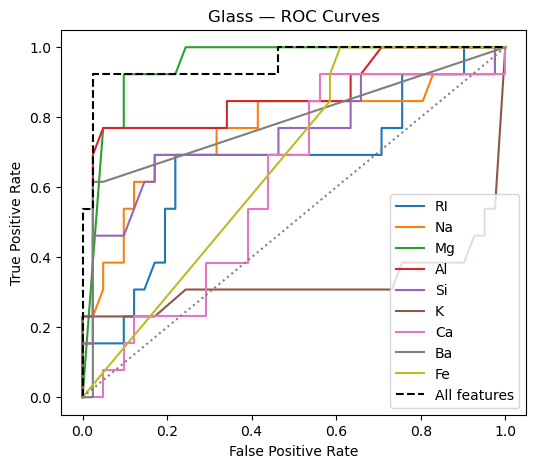

In [22]:
# Cell 4: ROC Curves (Single-Feature vs. All-Features)
plt.figure(figsize=(6,5))

# univariate
for feat in X.columns:
    # retrain with scaling for fair comparison
    uni_pipe = Pipeline([
        ('scale', StandardScaler()),
        ('lr', LogisticRegression(solver='liblinear'))
    ])
    uni_pipe.fit(X_train[[feat]], y_train)
    pr = uni_pipe.predict_proba(X_test[[feat]])[:,1]
    fpr, tpr, _ = roc_curve(y_test, pr)
    plt.plot(fpr, tpr, label=feat)

# multivariate
plt.plot(fpr_all, tpr_all, 'k--', label='All features')

plt.plot([0,1],[0,1],'gray', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Glass — ROC Curves')
plt.legend(loc='lower right')
plt.show()


## 5: K-Means on Iris — Inertia & Silhouette vs k

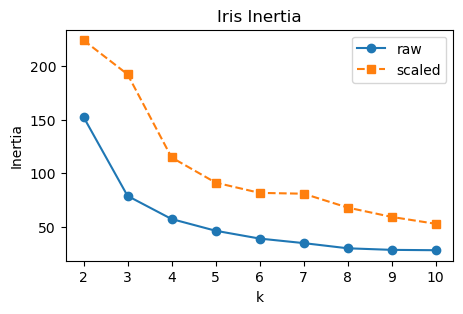

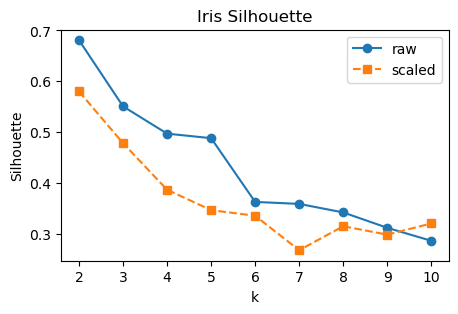

In [23]:
ks = range(2,11)
in_raw, sil_raw = [], []
in_scl, sil_scl = [], []

scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_X)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    lbls = km.fit_predict(iris_X)
    in_raw.append(km.inertia_)
    sil_raw.append(silhouette_score(iris_X, lbls))
    
    km2 = KMeans(n_clusters=k, random_state=42)
    lbls2 = km2.fit_predict(iris_scaled)
    in_scl.append(km2.inertia_)
    sil_scl.append(silhouette_score(iris_scaled, lbls2))

# plot Inertia
plt.figure(figsize=(5,3))
plt.plot(ks, in_raw, 'o-', label='raw')
plt.plot(ks, in_scl, 's--', label='scaled')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Iris Inertia'); plt.legend()

# plot Silhouette
plt.figure(figsize=(5,3))
plt.plot(ks, sil_raw, 'o-', label='raw')
plt.plot(ks, sil_scl, 's--', label='scaled')
plt.xlabel('k'); plt.ylabel('Silhouette'); plt.title('Iris Silhouette'); plt.legend()

plt.show()


## 6. K-Means on Food Nutrients — Inertia & Silhouette vs k

In [24]:
ks = range(2,11)
in_raw, sil_raw = [], []
in_scl, sil_scl = [], []

scaler = StandardScaler()
food_scaled = scaler.fit_transform(food_X)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42).fit(food_X)
    in_raw.append(km.inertia_)
    sil_raw.append(silhouette_score(food_X, km.labels_))
    
    km2 = KMeans(n_clusters=k, random_state=42).fit(food_scaled)
    in_scl.append(km2.inertia_)
    sil_scl.append(silhouette_score(food_scaled, km2.labels_))

pd.DataFrame({
    'k': ks,
    'inertia_raw': in_raw,   'silhouette_raw': sil_raw,
    'inertia_scaled': in_scl,'silhouette_scaled': sil_scl
}).round(2)


,k,inertia_raw,silhouette_raw,inertia_scaled,silhouette_scaled
0,2,4.314682e+11,0.69,296527.99,0.34
1,3,2.435462e+11,0.55,279000.06,0.45
2,4,2.083105e+11,0.48,263792.00,0.22
3,5,1.357141e+11,0.49,249615.58,0.20
4,6,1.107117e+11,0.51,239333.29,0.23
5,7,1.040926e+11,0.51,224238.13,0.20
6,8,9.245469e+10,0.45,219427.43,0.19
7,9,8.590317e+10,0.46,211196.95,0.20
8,10,7.617942e+10,0.46,202457.59,0.19


- Threshold tuning shows how Accuracy/Precision/Recall shift when you move your decision cutoff.

- ROC AUC summarizes separability across all thresholds.

- Inertia always decreases as k increases; Silhouette often peaks at some intermediate k, indicating a balance of compactness and separation (not a single “right” k).

- Scaling usually makes clusters more balanced when features differ in scale.

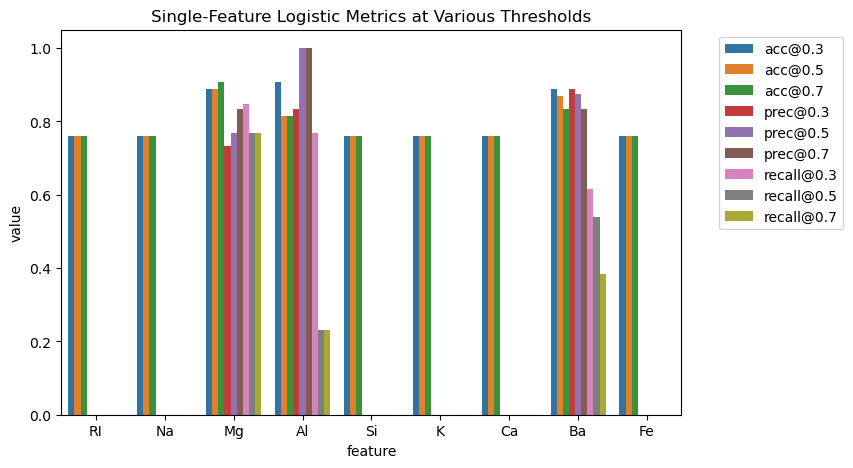

In [25]:
# Cell 7: Seaborn barplots of Logistic metrics per feature
import seaborn as sns

# assume `rows` from Cell 2 and `res` from Cell 3 are in DataFrames `uni_df` and `multi_df`
uni_df = pd.DataFrame(rows).melt(
    id_vars='feature',
    value_vars=[f'acc@{t}' for t in thresholds] +
               [f'prec@{t}' for t in thresholds] +
               [f'recall@{t}' for t in thresholds],
    var_name='metric', value_name='value'
)
plt.figure(figsize=(8,5))
sns.barplot(data=uni_df, x='feature', y='value', hue='metric')
plt.title('Single-Feature Logistic Metrics at Various Thresholds')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.show()


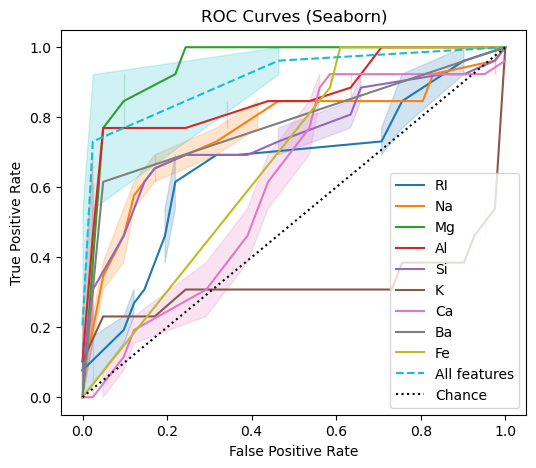

In [26]:
# Cell 8: Seaborn ROC curves
plt.figure(figsize=(6,5))
for feat in X.columns:
    probs = Pipeline([
        ('scale', StandardScaler()),
        ('lr', LogisticRegression(solver='liblinear'))
    ]).fit(X_train[[feat]], y_train).predict_proba(X_test[[feat]])[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    sns.lineplot(x=fpr, y=tpr, label=feat)
sns.lineplot(x=fpr_all, y=tpr_all, linestyle='--', label='All features')
plt.plot([0,1],[0,1],'k:', label='Chance')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Seaborn)')
plt.legend(loc='lower right')
plt.show()


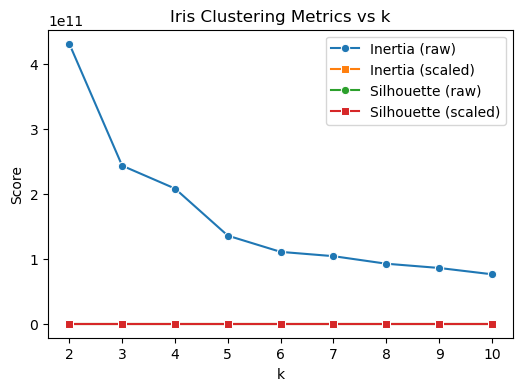

In [27]:
# Cell 9: Seaborn lineplots for Iris clustering metrics
plt.figure(figsize=(6,4))
sns.lineplot(x=list(ks), y=in_raw,   marker='o', label='Inertia (raw)')
sns.lineplot(x=list(ks), y=in_scl,   marker='s', label='Inertia (scaled)')
sns.lineplot(x=list(ks), y=sil_raw,  marker='o', label='Silhouette (raw)')
sns.lineplot(x=list(ks), y=sil_scl,  marker='s', label='Silhouette (scaled)')
plt.xlabel('k'); plt.ylabel('Score')
plt.title('Iris Clustering Metrics vs k')
plt.legend()
plt.show()


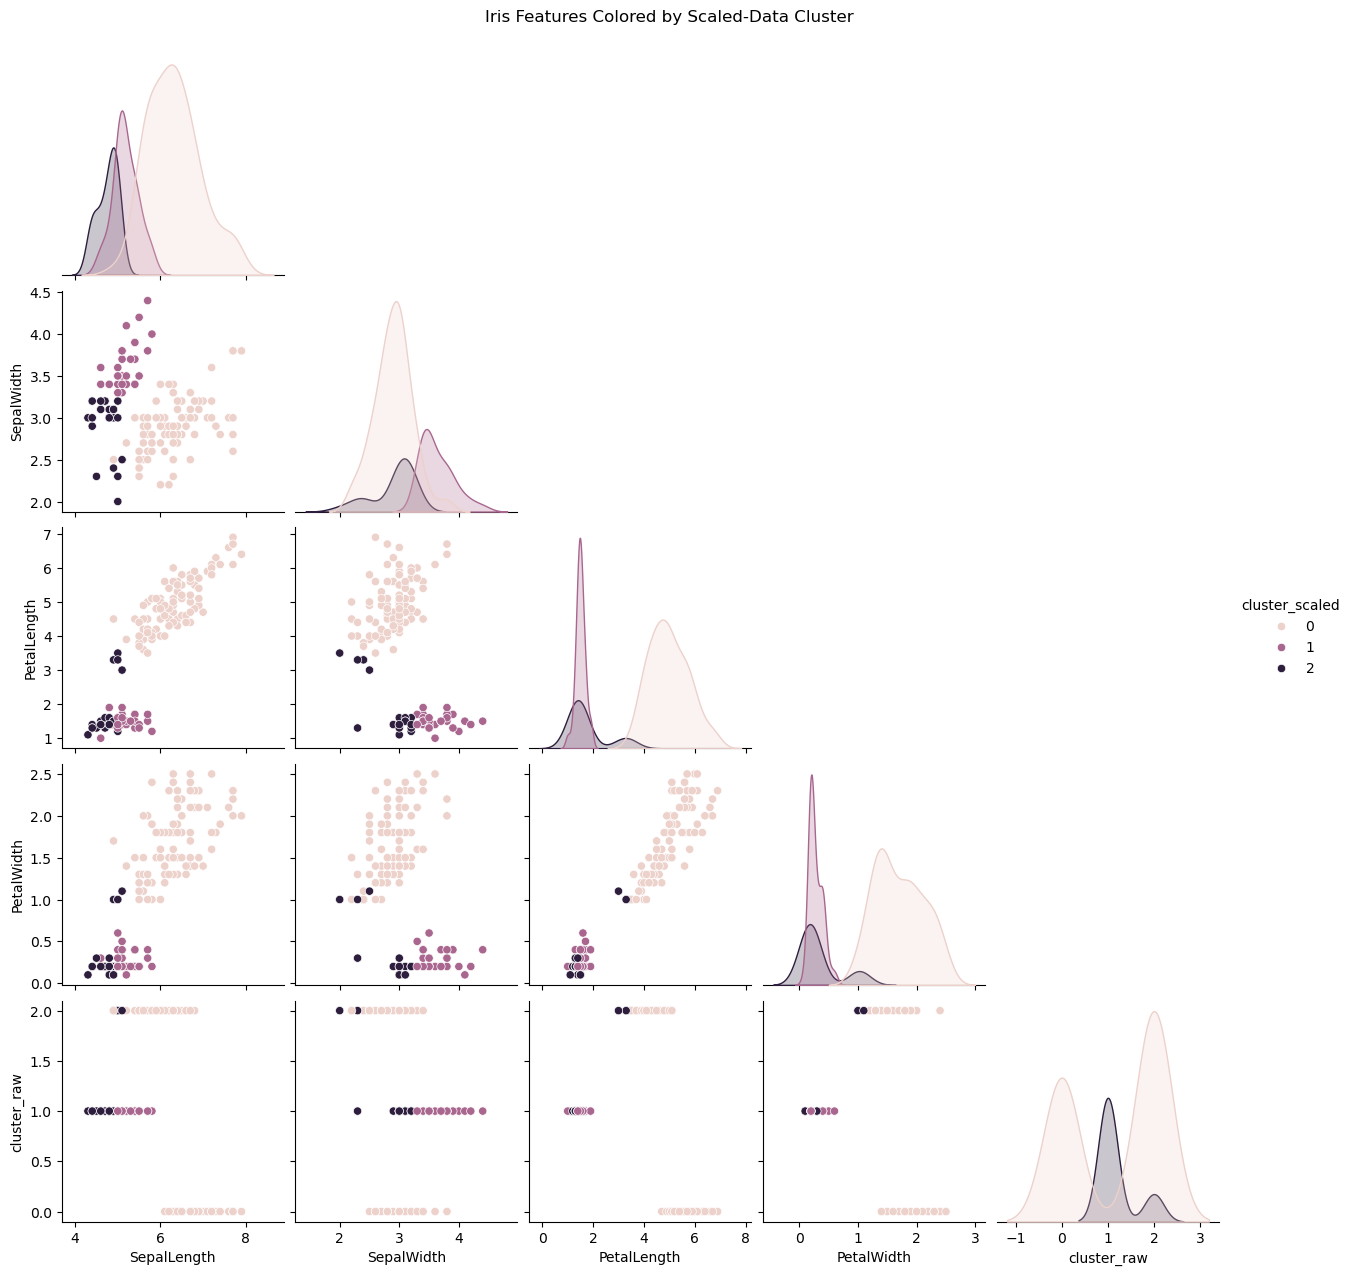

In [28]:
# Cell 10: Seaborn pairplot of Iris clusters
iris_clustered = iris_X.copy()
iris_clustered['cluster_raw']   = KMeans(n_clusters=3, random_state=42).fit_predict(iris_X)
iris_clustered['cluster_scaled']= KMeans(n_clusters=3, random_state=42).fit_predict(iris_scaled)
sns.pairplot(iris_clustered, hue='cluster_scaled', corner=True)
plt.suptitle('Iris Features Colored by Scaled-Data Cluster', y=1.02)
plt.show()


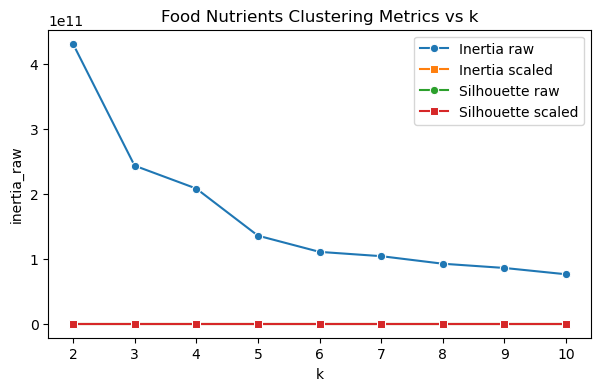

In [29]:
# Cell 11: Seaborn lineplot for Food dataset clustering metrics
food_df = pd.DataFrame({
    'k': ks,
    'inertia_raw': in_raw,   # if overwritten, recompute or rename accordingly
    'silhouette_raw': sil_raw,
    'inertia_scaled': in_scl,
    'silhouette_scaled': sil_scl
})
plt.figure(figsize=(7,4))
sns.lineplot(data=food_df, x='k', y='inertia_raw',   marker='o', label='Inertia raw')
sns.lineplot(data=food_df, x='k', y='inertia_scaled', marker='s', label='Inertia scaled')
sns.lineplot(data=food_df, x='k', y='silhouette_raw',marker='o', label='Silhouette raw')
sns.lineplot(data=food_df, x='k', y='silhouette_scaled',marker='s', label='Silhouette scaled')
plt.title('Food Nutrients Clustering Metrics vs k')
plt.show()
